# Multi Layer Perceptron

An MLP created by Ga Jun Young, 16440714

Supports 3 cases:
1. Learning XOR function
2. Learning Sin function
3. Letter recognition using the dataset provided by UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/Letter+Recognition



## `Import libraries`

In [0]:
__author__ = 'Ga Jun Young - 16440714'

import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings
np.random.seed(2020)
warnings.filterwarnings('ignore')

## `1. Setup activation and activation derivative functions`

In [0]:
def sigmoid(Z):
  """
  Sigmoid forward activation
  :param Z: linear activation
  :return: sigmoid activation output of Z
  """
  return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
  """
  Sigmoid derivative
  :param A: gradient of loss with respect to activation
  :return: sigmoid gradient loss
  """
  return A * (1 - A)

def tanh(Z):
  """
  Tanh forward activation
  :param Z: linear activation
  :return: tanh activation output of Z
  """
  return np.tanh(Z)

def tanh_derivative(A):
  """
  Tanh derivative
  :param A: gradient of loss with respect to activation
  :return: tanh gradient loss
  """
  return 1.0 - A**2

def linear(Z):
  """
  Identity Activation
  :param Z: linear activation
  :return: same value as input Z
  """
  return Z

def linear_derivative(A):
  """
  Linear derivative
  :param A: gradient of loss with respect to activation
  :return: same value as input A
  """
  return A

def softmax(Z):
  """
  Softmax activation of vector Z
  :param Z: linear activation
  :return: softmax activation output of Z
  """
  exps = np.exp(Z - np.max(Z))
  return exps / np.sum(exps)

def softmax_derivative(A):
  """
  Softmax derivative
  :param A: gradient of loss with respect to activation
  :return: softmax gradient loss
  """
  return softmax(A) * (1 - softmax(A))

## `2. Setup loss functions`

In [0]:
def squared_error(Y_hat, Y):
  """
  Calculate squared error between predicted and actual output
  :param Y_hat: predicted output
  :param Y: expected output
  :return: The square error loss
  """
  return 0.5 * np.sum((Y_hat - Y) ** 2)

def cross_entropy(Y_hat, Y):
  """
  Calculate cross entropy between predicted and actual output
  :param Y_hat: predicted output
  :param Y: expected output
  :return: The cross entropy
  """
  return -np.sum(np.nan_to_num((Y * np.log(Y_hat)) + ((1-Y) * np.log(1-Y_hat))))

## `3. Setup generic MLP Model`

In [0]:
class MLP:
  def __init__(self, n_i, n_h, n_o, learning_rate=0.1, epochs=3000, activation='Sigmoid', output_activation='Sigmoid', verbose=False):
    """
    Initialize neural network
    :param n_i: number of units in the input layer
    :param n_h: number of units in the hidden layer
    :param n_o: number of units in the output layer
    :param learning_rate: learning rate of the gradient descent (hyperparameter)
    :param epochs: number of iteration updates through dataset for training (hyperparameter)
    :param activation: string ('Tanh' or 'Sigmoid') activation for layer
    :param output_activation:  string ('Linear' or 'Sigmoid') activation for output layer
    :param verbose: boolean to check if we want to print outputs
    """
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.verbose = verbose
    self.output_type = output_activation

    # init activation functions & loss function
    self.activation, self.activation_d = self.init_activation_func(activation)
    self.out_activation, self.out_activation_d = self.init_activation_func(output_activation)
    self.loss_func = self.init_loss_func()

    # init layers, weights
    self.I = np.ones(n_i + 1) # + 1 bias
    self.H = np.ones(n_h)
    self.O = np.ones(n_o)
    self.randomize()

  def init_activation_func(self, activation):
    """
    :param activation: string input to use the correct activation for layer
    :return: The assigned activation and activation derivative
    """
    if activation == 'Tanh':
      return tanh, tanh_derivative
    elif activation == 'Softmax':
      return softmax, softmax_derivative
    elif activation == 'Linear':
      return linear, linear_derivative
    else:
      return sigmoid, sigmoid_derivative

  def init_loss_func(self):
    """
    :return: return the loss function based on number of outputs
    """
    if self.n_o > 1: # if the output > 1 then it is a classification problem
      return cross_entropy
    return squared_error # else regression problem
  
  def randomize(self):
    """
    Initialize weights and delta weights
    """
    # He init optimizes model
    self.W1 = np.random.randn(self.I.size, self.n_h) * np.sqrt(2 / self.I.size)
    self.W2 = np.random.randn(self.n_h, self.n_o) * np.sqrt(2 / self.n_h)
    self.dW1 = np.zeros((self.W1.shape))
    self.dW2 = np.zeros((self.W2.shape))

  def forward(self, I):
    """
    Compute the layer activations
    :param I: inputs
    :return O: final layer output (activation value)
    """

    # Hidden layer 
    self.I[:-1] = I # the last index is a bias, therefore we do not overwrite that bit
    Z1 = self.I @ self.W1
    self.H = self.activation(Z1)

    # Output layer
    Z2 = self.H @ self.W2
    self.O = self.out_activation(Z2)

    return self.O
  
  def backwards(self, target):
    """
    Compute back-propagation gradients
    :param target: ground truth output 
    """
    dZ2 = target - self.O

    # delta activation for output layer
    if self.output_type != 'Linear':
      dZ2 = dZ2 * self.out_activation_d(self.O)

    # delta activation for hidden layer
    dZ1 = (dZ2 @ self.W2.T) * self.activation_d(self.H)

    # compute gradient of weights
    self.dW1 = np.atleast_2d(self.I).T @ np.atleast_2d(dZ1)
    self.dW2 = np.atleast_2d(self.H).T @ np.atleast_2d(dZ2)
  
  def update_weights(self):
    """
    update weights using gradient descent
    """
    self.W1 += self.learning_rate * self.dW1
    self.W2 += self.learning_rate * self.dW2 
    self.dW1 = np.zeros((self.W1.shape))
    self.dW2 = np.zeros((self.W2.shape))

  def fit(self, X, Y):
    """
    Optimise model parameters by performing gradient descent
    :param X: n data samples 
    :param Y: ground truth label vector of size (n, n_y)
    :return:
    error_log: list of loss values for every 100 updates
    """
    error_log = []
    for i in range (1, self.epochs):
      error = 0
      for j, row in enumerate(X):
        self.forward(row) # feed forward inputs to output
        error += self.loss_func(self.O, Y[j])#/(len(Y[j])) # calculate loss
        self.backwards(Y[j]) # back prop
        self.update_weights() 
      
      if (i % 100 == 0):
        error = error / Y.shape[0]
        error_log.append(error.item())
        if self.verbose:
            print("Error after {} epochs: {:.3f}".format(i, error))

    return error_log

  def predict(self, X):
    """
    Predict class label using model parameters
    :param X: n data samples, shape (n, n_x)
    :returns: vector with class predictions for examples in X, shape (n, n_y)
    """
    Y_hat = list()

    for i, row in enumerate(X):
      predicted_output = self.forward(row)

      if self.n_o > 1:
        np_output = np.zeros(self.n_o) # 0 numpy array - no letter has been assigned
        np_output[np.argmax(predicted_output)] = 1 # assign 1 to the corresponding index
        Y_hat.append(np_output)
      else:
        Y_hat.append(predicted_output)
    
    return np.array(Y_hat)

  def model(self, X_train, Y_train, X_test, Y_test):
    """
    train and evaluate the layer model
    :param X_train: training set a numpy array of shape (n_train, n_i)
    :param Y_train: training groud truth vector of size (n_train, n_o)
    :param X_test: testing set a numpy array of shape (n_test, n_i)
    :param Y_test: testing groud truth vector of size (n_test, n_o)

    :return:
    model -- dictionary
        ERROR -- log of training loss
        ACC -- array with training and testing accuracies
        LR -- learning rate
        Y_hat_test - predicted output array
    """
    error_log = self.fit(X_train, Y_train)
    Y_hat_train = self.predict(X_train)
    Y_hat_test = self.predict(X_test)
    test_acc = train_acc = 0

    # calculate train and test accuracy
    if self.n_o > 1: 
      for i, _ in enumerate(Y_train):
          if np.argmax(Y_hat_train[i]) == np.argmax(Y_train[i]):
              train_acc += 1.
      for i, row in enumerate(Y_test):
          if np.argmax(Y_hat_test[i]) == np.argmax(Y_test[i]):
              test_acc += 1.
      
      train_acc = (train_acc / len(Y_train)) * 100
      test_acc = (test_acc / len(Y_test)) * 100
    else:
      train_acc = (100 - np.mean(np.abs(Y_hat_train - Y_train)) * 100)
      test_acc = (100 - np.mean(np.abs(Y_hat_test - Y_test)) * 100)

    print("{:.1f}% training acc.".format(train_acc))
    print("{:.1f}% test acc.".format(test_acc))

    return {"ERROR": error_log, "ACC": [train_acc, test_acc], "LR": self.learning_rate, "Y_hat_test": Y_hat_test}
        

# Part 1: XOR Function

[0, 0] = 0 <br>
[0, 1] = 1<br>
[1, 0] = 1<br>
[1, 1] = 0<br>

## `Create XOR training and test dataset`

In [0]:
def xor_dataset():
    """
    Represents XOR function

    :return:
    X_train/X_test: 2 inputs per output (size 4 and 4 respectively)
    Y_train/Y_test: 1 output per 2 inputs (size 4 and 4 respectively)
    n_h: number of units in the hidden layer
    """
    X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    Y_train = np.array([[0], [1], [1], [0]])
    X_test = np.array([[0, 1], [0, 0], [1, 1], [0, 1]])
    Y_test = np.array([[1], [0], [0], [1]])
    n_h = 4
    return (X_train, Y_train), (X_test, Y_test), n_h

## `Load and setup model`

In [86]:
(X_train, Y_train), (X_test, Y_test), NH = xor_dataset()
print('=='* 20)
print('X Train shape: %8s | Y Train shape: %8s ' % (X_train.shape, Y_train.shape))
print('X Test shape:  %8s | Y Test shape:  %8s' %(X_test.shape, Y_test.shape))
print('=='* 20)
np.random.seed(2020)
xor_mlp = MLP(2, 64, 1, epochs=3000, learning_rate=0.5, 
              activation='Tanh', output_activation='Sigmoid', verbose=True)
model = xor_mlp.model(X_train, Y_train, X_test, Y_test)

print("\n\n =============== Test various iterations ===============")
for i, hidden_units in enumerate([4, 8, 16, 32, 64, 128]):
    np.random.seed(2020)
    print("XOR with {} hidden units".format(hidden_units))
    test = MLP(2, hidden_units, 1, epochs=3000, learning_rate=0.5, 
              activation='Tanh', output_activation='Sigmoid', verbose=False)
    test_model = test.model(X_train, Y_train, X_test, Y_test)

X Train shape:   (4, 2) | Y Train shape:   (4, 1) 
X Test shape:    (4, 2) | Y Test shape:    (4, 1)
Error after 100 epochs: 0.003
Error after 200 epochs: 0.001
Error after 300 epochs: 0.001
Error after 400 epochs: 0.000
Error after 500 epochs: 0.000
Error after 600 epochs: 0.000
Error after 700 epochs: 0.000
Error after 800 epochs: 0.000
Error after 900 epochs: 0.000
Error after 1000 epochs: 0.000
Error after 1100 epochs: 0.000
Error after 1200 epochs: 0.000
Error after 1300 epochs: 0.000
Error after 1400 epochs: 0.000
Error after 1500 epochs: 0.000
Error after 1600 epochs: 0.000
Error after 1700 epochs: 0.000
Error after 1800 epochs: 0.000
Error after 1900 epochs: 0.000
Error after 2000 epochs: 0.000
Error after 2100 epochs: 0.000
Error after 2200 epochs: 0.000
Error after 2300 epochs: 0.000
Error after 2400 epochs: 0.000
Error after 2500 epochs: 0.000
Error after 2600 epochs: 0.000
Error after 2700 epochs: 0.000
Error after 2800 epochs: 0.000
Error after 2900 epochs: 0.000
99.1% tra

## `Display tabulated data & error graph`

==============================  XOR Table  ==============================
Input: [0 1] | expected: [1] | prediction: [0.99046413] | accuracy: 99.0%
Input: [0 0] | expected: [0] | prediction: [0.00811682] | accuracy: 99.2%
Input: [1 1] | expected: [0] | prediction: [0.01007462] | accuracy: 99.0%
Input: [0 1] | expected: [1] | prediction: [0.99046413] | accuracy: 99.0%




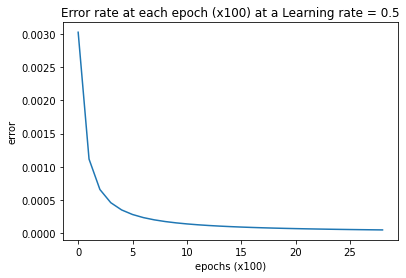

In [87]:
# Grab model's cached data
Y_hat_test = model['Y_hat_test']
ACC = model['ACC']

# Display Tabulated results
print("==" * 15 + "  XOR Table  " + "==" * 15)
for i, row in enumerate(Y_test):
    test_acc = (100 - np.mean(np.abs(Y_hat_test[i] - Y_test[i])) * 100)
    print("Input: {} | expected: {} | prediction: {} | accuracy: {:.1f}%".format(X_test[i], row, Y_hat_test[i], test_acc))

print('\n')
plt.plot(model['ERROR'])
plt.ylabel('error')
plt.xlabel('epochs (x100)')
plt.title("Error rate at each epoch (x100) at a Learning rate = {}".format(model['LR']))
plt.show()

# Part 2: Sin Function

## `Create sin training and test dataset`

200 vectors, 4 components each. Each component is randomly initialized between -1 and 1. 

Input: [x1, x2, x3, x4] <br>
Output: sin(x1-x2+x3-x4)

In [0]:
def sin_dataset():
  """
  Represents sin(x1 - x2 + x3 - x4) function

  :return:
  X_train/X_test: 4 inputs per output (size 150 and 50 respectively)
  Y_train/Y_test: 1 output per 4 inputs (size 150 and 50 respectively)
  n_h: number of units in the hidden layer
  """
  X_train = np.random.uniform(-1, 1, size=(150, 4))  # vectors in range [-1, 1]
  Y_train = []

  for row in X_train:
      Y_train.append([np.sin(row[0] - row[1] + row[2] - row[3])])

  X_test = np.random.uniform(-1, 1, size=(50, 4))
  Y_test = []
  for row in X_test:
      Y_test.append([np.sin(row[0] - row[1] + row[2] - row[3])])

  n_h = 10
  return (X_train, np.array(Y_train)), (X_test, np.array(Y_test)), n_h

## `Load and setup model`


In [93]:
(X_train, Y_train), (X_test, Y_test), n_h = sin_dataset()
print('=='* 20)
print('X Train shape: %8s | Y Train shape: %8s ' % (X_train.shape, Y_train.shape))
print('X Test shape:  %8s | Y Test shape:  %8s' %(X_test.shape, Y_test.shape))
print('=='* 20)

np.random.seed(2020)
mlp_sin_model = MLP(4, 5, 1, learning_rate=0.1, epochs=1300, 
                    activation='Tanh', output_activation='Linear', verbose=True)
sin_model_results = mlp_sin_model.model(X_train, Y_train, X_test, Y_test)

print("\n\n =============== Test various iterations ===============")
for i, hidden_units in enumerate([5, 6, 7, 8, 9]):
    np.random.seed(2020)
    print("XOR with {} hidden units".format(hidden_units))
    test = MLP(4, hidden_units, 1, epochs=1300, learning_rate=0.1, 
              activation='Tanh', output_activation='Linear', verbose=False)
    test_model = test.model(X_train, Y_train, X_test, Y_test)

X Train shape: (150, 4) | Y Train shape: (150, 1) 
X Test shape:   (50, 4) | Y Test shape:   (50, 1)
Error after 100 epochs: 0.005
Error after 200 epochs: 0.004
Error after 300 epochs: 0.001
Error after 400 epochs: 0.000
Error after 500 epochs: 0.000
Error after 600 epochs: 0.000
Error after 700 epochs: 0.000
Error after 800 epochs: 0.000
Error after 900 epochs: 0.000
Error after 1000 epochs: 0.000
Error after 1100 epochs: 0.000
Error after 1200 epochs: 0.000
99.8% training acc.
99.8% test acc.


 =============== Test various iterations ===============
XOR with 5 hidden units
99.8% training acc.
99.8% test acc.
XOR with 6 hidden units
99.8% training acc.
99.7% test acc.
XOR with 7 hidden units
99.8% training acc.
99.8% test acc.
XOR with 8 hidden units
99.6% training acc.
99.5% test acc.
XOR with 9 hidden units
99.5% training acc.
99.5% test acc.


## `Display graph of epochs against error`

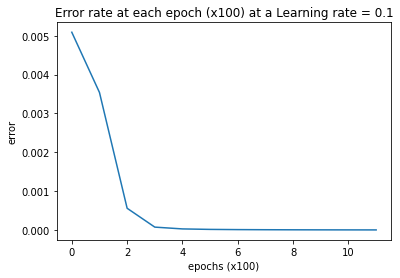

In [94]:
plt.plot(sin_model_results['ERROR'])
plt.ylabel('error')
plt.xlabel('epochs (x100)')
plt.title("Error rate at each epoch (x100) at a Learning rate = {}".format(sin_model_results['LR']))
plt.show()

## `Display tabulated data of expected and predictions`

In [95]:
print("==" * 17 + "  Sin Expected & Predicted Table  " + "==" * 17)
Y_hat_test = sin_model_results['Y_hat_test']
for i, row in enumerate(Y_test):
    print("Input: %50s | expected: %8.5f | prediction: %8.5f" % (str(X_test[i]), row, Y_hat_test[i]))

==================================  Sin Expected & Predicted Table  ==================================
Input:  [-0.65478525  0.77369641 -0.26015498 -0.67209955] | expected: -0.85029 | prediction: -0.84978
Input:      [0.42961669 0.53903703 0.08423118 0.34574127] | expected: -0.36248 | prediction: -0.35888
Input:  [-0.51949023  0.77572813 -0.24658563 -0.8432137 ] | expected: -0.64314 | prediction: -0.64417
Input:  [-0.71167363 -0.60956959 -0.64982357  0.8386954 ] | expected: -0.99980 | prediction: -0.99738
Input:  [-0.60252347 -0.92436846 -0.06963475 -0.23952019] | expected:  0.47215 | prediction:  0.46857
Input:  [ 0.14801154  0.65404526 -0.51314082  0.78448075] | expected: -0.97301 | prediction: -0.97021
Input:  [-0.88770678  0.88591471 -0.90947856 -0.57835335] | expected: -0.86080 | prediction: -0.86439
Input:  [ 0.85492474  0.96147255 -0.38760103  0.23844235] | expected: -0.66880 | prediction: -0.67189
Input:  [-0.32618004 -0.80898763  0.3341625   0.2947731 ] | expected:  0.49879 | 

## `Display graph of expected vs test output`

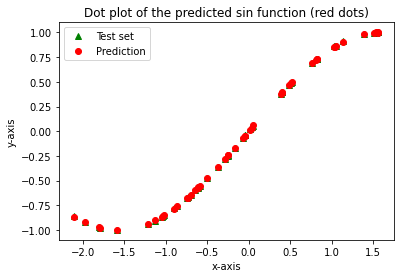

In [96]:
plt.figure(figsize=(6, 4))
x_test_plot = list(map(lambda a: a[0] - a[1] + a[2] - a[3], X_test))
plt.plot(x_test_plot, Y_test, 'g^', x_test_plot, Y_hat_test, 'ro')
plt.ylabel('y-axis')
plt.xlabel('x-axis')
plt.legend(('Test set', 'Prediction'))
plt.title('Dot plot of the predicted sin function (red dots)')
plt.show()

# Part 3: Letter Recognition

## `Load letter recognition dataset and split with 0.8 ratio`

The dataset holds 20,000 rows of data

The training set holds 16,000.
The test set holds 4,000.

Also, one hot encode the output labels

In [98]:
def letter_recognition_dataset():
  """
  Load the letter recognition dataset and split it with a 0.8 ratio
  """
  data_set = list()

  # Read data from csv
  with open('./letter-recognition.csv', 'r') as data_file:
      reader = csv.reader(data_file)
      for row in reader:
          row[0] = ord(row[0]) - ord('A')  # character to number value
          for i in range(1, len(row)):  # convert number strings to numbers
              row[i] = int(row[i])

          data_set.append(row)

  # Split data_set into 0.8 training set and 0.2 test set
  training_ratio = 0.8
  training_record_size = int(len(data_set) * 0.8)
  training_set = np.array(data_set[:training_record_size])
  test_set = np.array(data_set[training_record_size:])

  X_train = training_set[:, 1:]
  Y_train = training_set[:, 0]
  X_test = test_set[:, 1:]
  Y_test = test_set[:, 0]

  # Normalize, as the 16 numerical values were scaled to fit between 0 and 15
  X_train = X_train / 15  
  X_test = X_test / 15

  n_h = 30
  n_y = 26

  # one hot encoding - Find which letter is set for each training row 
  Y_train_letter = np.zeros((len(Y_train), n_y))
  for i, l in enumerate(Y_train):
      Y_train_letter[i][l] = 1

  Y_test_letter = np.zeros((len(Y_test), n_y))
  for i, l in enumerate(Y_test):
      Y_test_letter[i][l] = 1

  return (X_train, Y_train, Y_train_letter), (X_test, Y_test, Y_test_letter), n_h

(X_train, Y_train, Y_train_letter), (X_test, Y_test, Y_test_letter), n_h = letter_recognition_dataset()  
print('=='* 20)
print('X Train shape: %8s | Y Train shape: %8s ' % (X_train.shape, Y_train.shape))
print('X Test shape:  %8s | Y Test shape:  %8s' %(X_test.shape, Y_test.shape))
print('=='* 20)

X Train shape: (16000, 16) | Y Train shape: (16000,) 
X Test shape:  (4000, 16) | Y Test shape:   (4000,)


## `Setup letter recognition model`

In [0]:
recog_mlp = MLP(16, n_h, 26, epochs=1000, learning_rate=0.1, activation='Tanh', output_activation='Softmax', verbose=True)
model = recog_mlp.model(X_train, Y_train_letter, X_test, Y_test_letter)

print("\n\n =============== Test various iterations ===============")
for i, hidden_units in enumerate([10, 20, 30]):
    np.random.seed(2020)
    print("XOR with {} hidden units".format(hidden_units))
    test = MLP(16, hidden_units, 26, epochs=1000, learning_rate=0.1, activation='Tanh', output_activation='Softmax', verbose=False)
    test_model = test.model(X_train, Y_train, X_test, Y_test)

Error after 100 epochs: 0.747
Error after 200 epochs: 0.698
Error after 300 epochs: 0.944
Error after 400 epochs: 0.851
Error after 500 epochs: 0.793
Error after 600 epochs: 0.754
Error after 700 epochs: 0.992
Error after 800 epochs: 0.896
Error after 900 epochs: 0.886
81.9% training acc.
79.5% test acc.


 =============== Test various iterations ===============
XOR with 10 hidden units
0.0% training acc.
0.0% test acc.
XOR with 20 hidden units


## `Display graph of epochs against error`



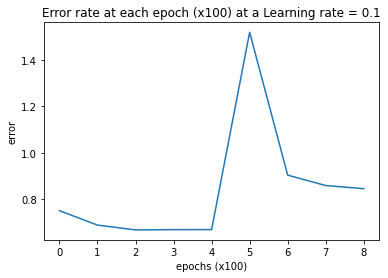

In [54]:
plt.plot(model['ERROR'])
plt.ylabel('error')
plt.xlabel('epochs (x100)')
plt.title("Error rate at each epoch (x100) at a Learning rate = {}".format(model['LR']))
plt.show()

## `Display tabulated data of expected and predicted output`

In [55]:
# Load cached model data
Y_hat_test = model['Y_hat_test']

# Create letter dictionary
test_dictionary = {chr(i + 65): 0 for i in range(26)}
prediction_dictionary = {chr(i + 65): 0 for i in range(26)}
correct_dictionary = {chr(i + 65): 0 for i in range(26)}

# Update dictionaries based on expected and predicted output
for i, _ in enumerate(Y_test):
    test_dictionary[chr(int(Y_test[i]) + ord('A'))] += 1
    max_arg = np.argmax(Y_hat_test[i])
    prediction_dictionary[chr(max_arg + 65)] += 1

    if Y_test[i] == max_arg:
      correct_dictionary[chr(max_arg + 65)] += 1

print('==' * 40)
print('Test Sample Size: %d | Correctly Predicted Sample Size: %d | Accuracy: %.3f' %
      (len(Y_test), sum(correct_dictionary.values()), sum(correct_dictionary.values())/len(Y_test)))
print('==' * 40)

for key, value in test_dictionary.items():
  print('%s => Test size: %4d | Predicted Size: %4d | Correctly Predicted Size: %4d | Accuracy: %.3f' %
         (key, value, prediction_dictionary[key], correct_dictionary[key], correct_dictionary[key]/value))

Test Sample Size: 4000 | Correctly Predicted Sample Size: 3212 | Accuracy: 0.803
A => Test size:  156 | Predicted Size:  161 | Correctly Predicted Size:  133 | Accuracy: 0.853
B => Test size:  136 | Predicted Size:  140 | Correctly Predicted Size:  105 | Accuracy: 0.772
C => Test size:  142 | Predicted Size:  156 | Correctly Predicted Size:  120 | Accuracy: 0.845
D => Test size:  167 | Predicted Size:  203 | Correctly Predicted Size:  146 | Accuracy: 0.874
E => Test size:  152 | Predicted Size:  138 | Correctly Predicted Size:  111 | Accuracy: 0.730
F => Test size:  153 | Predicted Size:  139 | Correctly Predicted Size:  118 | Accuracy: 0.771
G => Test size:  164 | Predicted Size:  179 | Correctly Predicted Size:  124 | Accuracy: 0.756
H => Test size:  151 | Predicted Size:   87 | Correctly Predicted Size:   75 | Accuracy: 0.497
I => Test size:  165 | Predicted Size:  182 | Correctly Predicted Size:  142 | Accuracy: 0.861
J => Test size:  148 | Predicted Size:  119 | Correctly Predicte